# PREPROCESSAMENTO
Esse arquivo define funções de extração de características. Preferẽncia para o uso de léxicos

### Léxico de Cláudia Freitas

Uso do léxico encontrado <a href = http://www.scielo.br/pdf/rbla/v13n4/aop2813.pdf>neste artigo</a>.
Peguei o léxico de substantivos desse artigo (por enquanto) e salvei num arquivo txt. É necessário uma expressão regular para extrair as palavras do arquivo. 

As palavras encontram-se na seguinte forma: [word];

In [1]:
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from database_utils import DatabaseConnector, build_dataframe, normalize_text
from sklearn.cross_validation import StratifiedKFold

def extract_words(filename):
    import re
                       
    f = open(filename, 'r')
    file_content = ''.join(f.readlines())
    f.close()
    
    words = re.findall(r'\[(\w+)\]', file_content)
    return words

def get_data_from_db(sentiment = None):
    db_connector = DatabaseConnector('localhost', 'root', '12345', 'CORPUS_VIES')
    if sentiment != None:
        retrieved_data = db_connector.getDataBySentiment(sentiment)
    else:
        retrieved_data = db_connector.getDataTextAndLabel()

    return retrieved_data


# Recuperação dos textos - treinar o modelo somente com as classes POS e NEG
all_data = get_data_from_db()
all_data = all_data[(all_data["labels"] == "PO") | (all_data["labels"] == "NG")]
print('Textos carregados')

subs_pos = extract_words('Recursos/Claudia Freitas/subs_pos')
subs_neg = extract_words('Recursos/Claudia Freitas/subs_neg')
verbs_pos = extract_words('Recursos/Claudia Freitas/verbs_pos')
verbs_neg = extract_words('Recursos/Claudia Freitas/verbs_neg')
adj_pos = extract_words('Recursos/Claudia Freitas/adj_pos')
adj_neg = extract_words('Recursos/Claudia Freitas/adj_neg')
print('Léxico carregado')

Textos carregados
Léxico carregado


/home/caiomagno/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Vetorizando os textos do corpus viés através do léxico de Cláudia Freitas
# USANDO MULTINOMIALNB()

def run_classifier(train, test, featurizer, classifier):
    p = Pipeline([("features", featurizer), ("classifier", classifier)])
    p.fit(train["texts"], train["labels"])
    predictions = p.predict(test["texts"])

    accuracy = accuracy_score(test["labels"], predictions, normalize=True)
    return accuracy
    

lexicon = list(set(subs_neg + subs_pos + verbs_neg +verbs_pos + adj_neg + adj_pos))
ftu = FeatureUnion([("unigram", CountVectorizer()), ("bigram", CountVectorizer(ngram_range=(1,2))), ("lexicon_vector", CountVectorizer(vocabulary= lexicon))])
print('Extração de features realizadas\n')

sKFold = StratifiedKFold(all_data['labels'], n_folds=10, shuffle=True)

print("Cross Validation:")
accuracy_average = np.array([])
for index, (train, test) in enumerate(sKFold):
    # Treinando um modelo Naive Bayes
    train_data = all_data.iloc[train]
    test_data = all_data.iloc[test]
    
    accuracy = run_classifier(train_data, test_data, ftu, MultinomialNB())
    accuracy_average = np.append(accuracy_average, accuracy)
    print("Fold ", index, " - Acuracia: ", accuracy)
    

print("\nAccuracia media: ", accuracy_average.mean())
print("Desvio padrão: ", accuracy_average.std())

Extração de features realizadas

Cross Validation:
Fold  0  - Acuracia:  0.69014084507
Fold  1  - Acuracia:  0.728571428571
Fold  2  - Acuracia:  0.757142857143
Fold  3  - Acuracia:  0.828571428571
Fold  4  - Acuracia:  0.785714285714
Fold  5  - Acuracia:  0.714285714286
Fold  6  - Acuracia:  0.585714285714
Fold  7  - Acuracia:  0.728571428571
Fold  8  - Acuracia:  0.728571428571
Fold  9  - Acuracia:  0.771428571429

Accuracia media:  0.731871227364
Desvio padrão:  0.0615618674769


## TESTE COM SVM

In [9]:
# Vetorizando os textos do corpus viés através do léxico de Cláudia Freitas
# USANDO SVM

from sklearn.svm import SVC

def run_classifier(train, test, featurizer, classifier):
    p = Pipeline([("features", featurizer), ("classifier", classifier)])
    p.fit(train["texts"], train["labels"])
    predictions = p.predict(test["texts"])

    accuracy = accuracy_score(test["labels"], predictions, normalize=True)
    return accuracy
    

lexicon = list(set(subs_neg + subs_pos + verbs_neg +verbs_pos + adj_neg + adj_pos))
ftu = FeatureUnion([("unigram", CountVectorizer()), ("bigram", CountVectorizer(ngram_range=(1,2))), ("lexicon_vector", CountVectorizer(vocabulary= lexicon))])
print('Extração de features realizadas\n')

sKFold = StratifiedKFold(all_data['labels'], n_folds=10, shuffle=True)

print("Cross Validation:")
accuracy_average = np.array([])
for index, (train, test) in enumerate(sKFold):
    train_data = all_data.iloc[train]
    test_data = all_data.iloc[test]
    
    accuracy = run_classifier(train_data, test_data, ftu, SVC(C = 316))
    accuracy_average = np.append(accuracy_average, accuracy)
    print("Fold ", index, " - Acuracia: ", accuracy)
    

print("\nAccuracia media: ", accuracy_average.mean())
print("Desvio padrão: ", accuracy_average.std())

Extração de features realizadas

Cross Validation:
Fold  0  - Acuracia:  0.647887323944
Fold  1  - Acuracia:  0.671428571429
Fold  2  - Acuracia:  0.757142857143
Fold  3  - Acuracia:  0.742857142857
Fold  4  - Acuracia:  0.671428571429
Fold  5  - Acuracia:  0.657142857143
Fold  6  - Acuracia:  0.714285714286
Fold  7  - Acuracia:  0.714285714286
Fold  8  - Acuracia:  0.728571428571
Fold  9  - Acuracia:  0.7

Accuracia media:  0.700503018109
Desvio padrão:  0.0353682330643


Comentário da <a href = http://scikit-learn.org/stable/modules/svm.html>página do sklearn</a>:

"The disadvantages of support vector machines include:
If the number of features is much greater than the number of samples, the method is likely to give poor performances."

## Analisando a matriz de features com PCA

In [5]:
%matplotlib notebook

from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

lexicon = list(set(subs_neg + subs_pos + verbs_neg +verbs_pos + adj_neg + adj_pos))
ftu = FeatureUnion([("unigram", CountVectorizer()), ("bigram", CountVectorizer(ngram_range=(1,2))), ("lexicon_vector", CountVectorizer(vocabulary= lexicon))])

bag_of_features = ftu.fit_transform(all_data["texts"])

print("Dimensionalidade do problema")
print("Dimensão do léxico: ", len(lexicon))
print("Dimensões da matriz: ", bag_of_features.shape)

pca = PCA()
pca.fit(bag_of_features.toarray())

Dimensionalidade do problema
Dimensão do léxico:  513
Dimensões da matriz:  (701, 31104)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

<IPython.core.display.Javascript object>


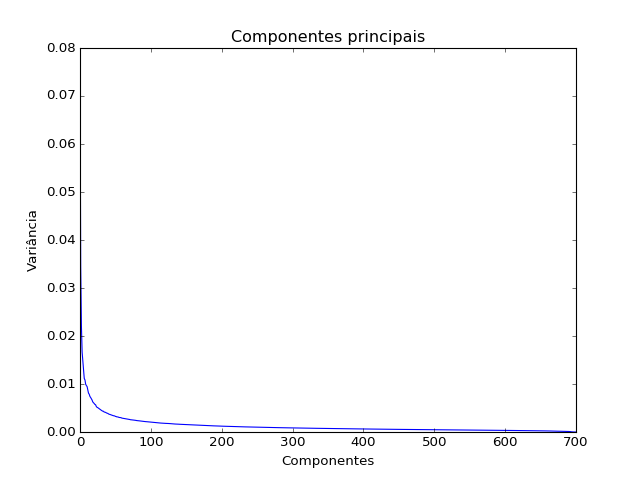

(<matplotlib.text.Text at 0x7f07d7f87780>,
 <matplotlib.text.Text at 0x7f07d7ff3c50>)

In [6]:
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.title("Componentes principais")
plt.xlabel("Componentes"), plt.ylabel("Variância")

# Como o numero de observações N é menor que o numero de variaveis P (N < P), o numero de componentes principais P 
# fica limitado ao numero de observações N

Reduzir o numero de componentes para 200

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components= 200)
bag_of_features_reduced = pca.fit_transform(bag_of_features.toarray())
bag_of_features_reduced.shape

(701, 200)

Aplicando o classificador MLPClassifier() realizando o CrossValidation

In [14]:
from sklearn.neural_network import MLPClassifier

sKFold = StratifiedKFold(all_data['labels'], n_folds=10, shuffle=True)
labels = all_data["labels"]

print("Cross Validation:")
accuracy_average = np.array([])
for index, (train, test) in enumerate(sKFold):
    train_data = bag_of_features_reduced[train]
    test_data = bag_of_features_reduced[test]
    
    classifier = MLPClassifier(activation= 'logistic', learning_rate='adaptive', alpha=1e-5, hidden_layer_sizes=(200, 100, 2), random_state=1)
    classifier.fit(train_data, labels.iloc[train])
    
    predictions = classifier.predict(test_data)
    accuracy = accuracy_score(labels.iloc[test], predictions, normalize=True)
    
    accuracy_average = np.append(accuracy_average, accuracy)
    print("Fold ", index, " - Acuracia: ", accuracy)
    

print("\nAccuracia media: ", accuracy_average.mean())
print("Desvio padrão: ", accuracy_average.std())

Cross Validation:
Fold  0  - Acuracia:  0.69014084507
Fold  1  - Acuracia:  0.771428571429
Fold  2  - Acuracia:  0.657142857143
Fold  3  - Acuracia:  0.7
Fold  4  - Acuracia:  0.7
Fold  5  - Acuracia:  0.571428571429
Fold  6  - Acuracia:  0.628571428571
Fold  7  - Acuracia:  0.657142857143
Fold  8  - Acuracia:  0.657142857143
Fold  9  - Acuracia:  0.657142857143

Accuracia media:  0.669014084507
Desvio padrão:  0.0495757662569


/home/caiomagno/anaconda3/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
